In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
drugs = pd.DataFrame({
    "drug name": ["aspirin", "paracetamol", "pseudoefedrin", "sulfogaiacol"],
    "canonical_smiles": ["CC(=O)Oc1ccccc1C(=O)O", "CC(=O)Nc1ccc(cc1)O", "CNC(C(c1ccccc1)O)C", "OC1=CC=CC=C1OC.O=S([O-])(C)=O.[K+]"]
})

In [3]:
drugs

,drug name,canonical_smiles
0,aspirin,CC(=O)Oc1ccccc1C(=O)O
1,paracetamol,CC(=O)Nc1ccc(cc1)O
2,pseudoefedrin,CNC(C(c1ccccc1)O)C
3,sulfogaiacol,OC1=CC=CC=C1OC.O=S([O-])(C)=O.[K+]


In [4]:
# Add ROMol objects to the dataframe
drugs['ROMol'] = drugs['canonical_smiles'].apply(Chem.MolFromSmiles)

# Calculate descriptors
drugs['MolecularMass'] = drugs['ROMol'].apply(lambda x: Descriptors.MolWt(x) if x is not None else None)
drugs['NumHAcceptors'] = drugs['ROMol'].apply(lambda x: Descriptors.NumHAcceptors(x) if x is not None else None)
drugs['NumHDonors'] = drugs['ROMol'].apply(lambda x: Descriptors.NumHDonors(x) if x is not None else None)
drugs['LogP'] = drugs['ROMol'].apply(lambda x: Descriptors.MolLogP(x) if x is not None else None)

# Display the dataframe with new descriptors
drugs[['drug name', 'canonical_smiles', 'MolecularMass', 'NumHAcceptors', 'NumHDonors', 'LogP']]

,drug name,canonical_smiles,MolecularMass,NumHAcceptors,NumHDonors,LogP
0,aspirin,CC(=O)Oc1ccccc1C(=O)O,180.159,3,1,1.3101
1,paracetamol,CC(=O)Nc1ccc(cc1)O,151.165,2,2,1.3506
2,pseudoefedrin,CNC(C(c1ccccc1)O)C,165.236,2,2,1.3279
3,sulfogaiacol,OC1=CC=CC=C1OC.O=S([O-])(C)=O.[K+],258.336,5,1,-2.4338


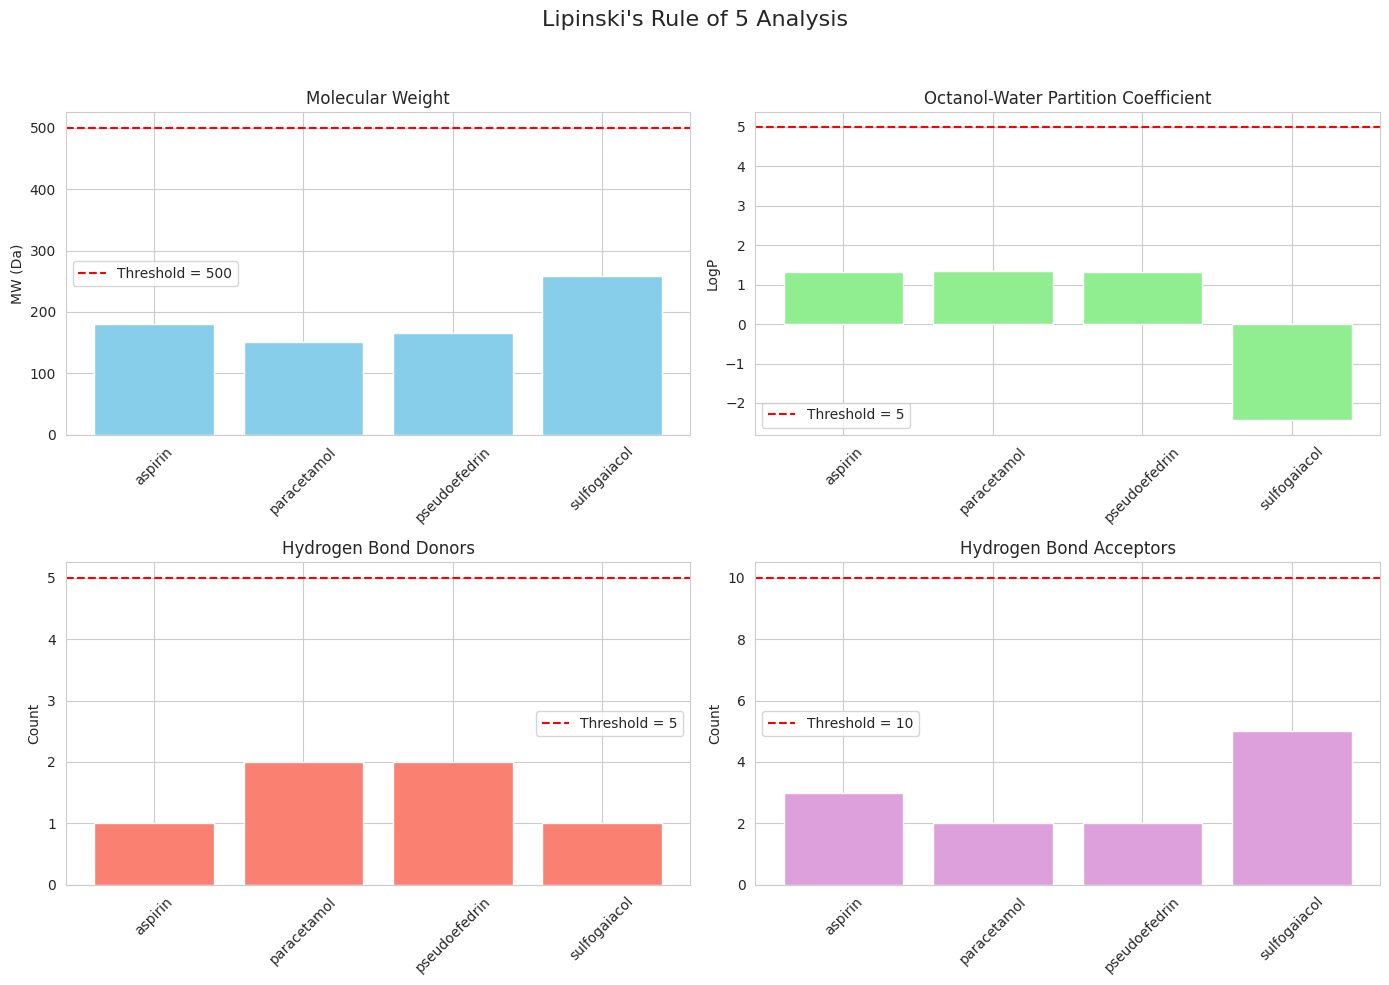

In [5]:
# Create a figure with subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Lipinski's Rule of 5 Analysis", fontsize=16)

# Plot Molecular Weight (< 500)
axs[0, 0].bar(drugs['drug name'], drugs['MolecularMass'], color='skyblue')
axs[0, 0].axhline(y=500, color='red', linestyle='--', label='Threshold = 500')
axs[0, 0].set_title('Molecular Weight')
axs[0, 0].set_ylabel('MW (Da)')
axs[0, 0].tick_params(axis='x', rotation=45)
axs[0, 0].legend()

# Plot LogP (< 5)
axs[0, 1].bar(drugs['drug name'], drugs['LogP'], color='lightgreen')
axs[0, 1].axhline(y=5, color='red', linestyle='--', label='Threshold = 5')
axs[0, 1].set_title('Octanol-Water Partition Coefficient')
axs[0, 1].set_ylabel('LogP')
axs[0, 1].tick_params(axis='x', rotation=45)
axs[0, 1].legend()

# Plot H-bond Donors (< 5)
axs[1, 0].bar(drugs['drug name'], drugs['NumHDonors'], color='salmon')
axs[1, 0].axhline(y=5, color='red', linestyle='--', label='Threshold = 5')
axs[1, 0].set_title('Hydrogen Bond Donors')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45)
axs[1, 0].legend()

# Plot H-bond Acceptors (< 10)
axs[1, 1].bar(drugs['drug name'], drugs['NumHAcceptors'], color='plum')
axs[1, 1].axhline(y=10, color='red', linestyle='--', label='Threshold = 10')
axs[1, 1].set_title('Hydrogen Bond Acceptors')
axs[1, 1].set_ylabel('Count')
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [6]:
def check_lipinski(smiles):
    """
    Check if a molecule follows Lipinski's Rule of 5.
    Returns True if the molecule passes at least 3 out of 4 rules.
    
    Lipinski's Rule of 5:
    - Molecular mass < 500 Da
    - LogP < 5
    - H-bond donors <= 5
    - H-bond acceptors <= 10
    """
    # Create molecule from SMILES
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return False, "Invalid SMILES"
    
    # Calculate properties
    molecular_mass = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    h_donors = Descriptors.NumHDonors(mol)
    h_acceptors = Descriptors.NumHAcceptors(mol)
    
    # Check each rule
    mass_passed = molecular_mass < 500
    logp_passed = logp < 5
    donors_passed = h_donors <= 5
    acceptors_passed = h_acceptors <= 10
    
    # Count passed rules
    rules_passed = sum([mass_passed, logp_passed, donors_passed, acceptors_passed])
    
    # Overall result - pass if at least 3 out of 4 rules are satisfied
    passed = rules_passed >= 3
    
    return pd.DataFrame({
        "passed": [passed],
        "Molecular mass": [molecular_mass],
        "LogP": [logp],
        "H-Donors": [h_donors],
        "H-Acceptors": [h_acceptors]
    })

In [7]:
import os

In [8]:
EGFR_df = pd.read_csv(os.path.join("..", "1_baza_chembl", "EGFR_combined.csv"))

In [9]:
EGFR_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value,canonical smiles,pIC50
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.300,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
2,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.000,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
3,62149,CHEMBL679674,Inhibition of Epidermal growth factor receptor,B,CHEMBL47940,=,nM,3200.0,CHEMBL203,Homo sapiens,IC50,uM,3.200,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850
4,78012,CHEMBL679949,Evaluated for inhibitory activity towards tyro...,B,CHEMBL432941,=,nM,8880.0,CHEMBL203,Homo sapiens,IC50,uM,8.880,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587


In [10]:
lipinski_results = EGFR_df['canonical smiles'].map(check_lipinski)

In [11]:
lipinski_results[0]

,passed,Molecular mass,LogP,H-Donors,H-Acceptors
0,True,383.814,4.45034,3,4


In [23]:
# Extract all lipinski results into a list of dataframes
lipinski_results_df_list = [df for df in lipinski_results]

# Combine results and add molecule identifiers
all_results = pd.DataFrame()
for i, result_df in enumerate(lipinski_results_df_list):
    result_df['molecule_chembl_id'] = EGFR_df.iloc[i]['molecule_chembl_id']
    result_df['canonical_smiles'] = EGFR_df.iloc[i]['canonical smiles']
    all_results = pd.concat([all_results, result_df], ignore_index=True)

# Filter only compounds that pass Lipinski's rule
lipinski_compliant = all_results[all_results['passed'] == True].reset_index(drop=True)

# Display the filtered results
print(f"Found {len(lipinski_compliant)} compounds that pass Lipinski's rule out of {len(EGFR_df)} total.")
lipinski_compliant[['molecule_chembl_id', 'Molecular mass', 'LogP', 'H-Donors', 'H-Acceptors', 'passed']]

Found 667 compounds that pass Lipinski's rule out of 862 total.


,molecule_chembl_id,Molecular mass,LogP,H-Donors,H-Acceptors,passed
0,CHEMBL68920,383.814,4.45034,3,4,True
1,CHEMBL137635,369.432,4.77200,1,6,True
2,CHEMBL306988,283.287,2.31056,2,4,True
3,CHEMBL47940,370.456,5.58790,1,5,True
4,CHEMBL432941,442.515,5.07900,3,3,True
...,...,...,...,...,...,...
662,CHEMBL2093753,412.478,4.09600,1,7,True
663,CHEMBL5412768,359.429,4.97330,1,5,True
664,CHEMBL5408234,458.953,5.96090,3,6,True
665,CHEMBL5206476,401.397,3.51320,2,4,True


In [25]:
# Merge the dataframes to add pIC50 values to lipinski_compliant
lipinski_compliant_with_pIC50 = lipinski_compliant.merge(
    EGFR_df[['molecule_chembl_id', 'pIC50']], 
    left_on='molecule_chembl_id',
    right_on='molecule_chembl_id',
    how='left'
)

# Drop the redundant molecule_chembl_id column
lipinski_compliant_with_pIC50.drop('molecule_chembl_id', axis=1, inplace=True)

# Display the result with pIC50 values
lipinski_compliant_with_pIC50.head()

,passed,Molecular mass,LogP,H-Donors,H-Acceptors,molecule_name,canonical_smiles,pIC50
0,True,383.814,4.45034,3,4,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,7.387216
1,True,369.432,4.77200,1,6,CHEMBL137635,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12,5.031517
2,True,283.287,2.31056,2,4,CHEMBL306988,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1,3.301030
3,True,370.456,5.58790,1,5,CHEMBL47940,Nc1ncnc2c1c(-c1ccc(Oc3ccccc3)cc1)cn2C1CCCC1,5.494850
4,True,442.515,5.07900,3,3,CHEMBL432941,COc1cccc(-c2ccc3c(c2)NC(=O)/C3=C\c2[nH]c3c(c2C...,5.051587


In [ ]:
# lipinski_compliant_with_pIC50.to_csv("EGFR_lipinski.csv", index=False)

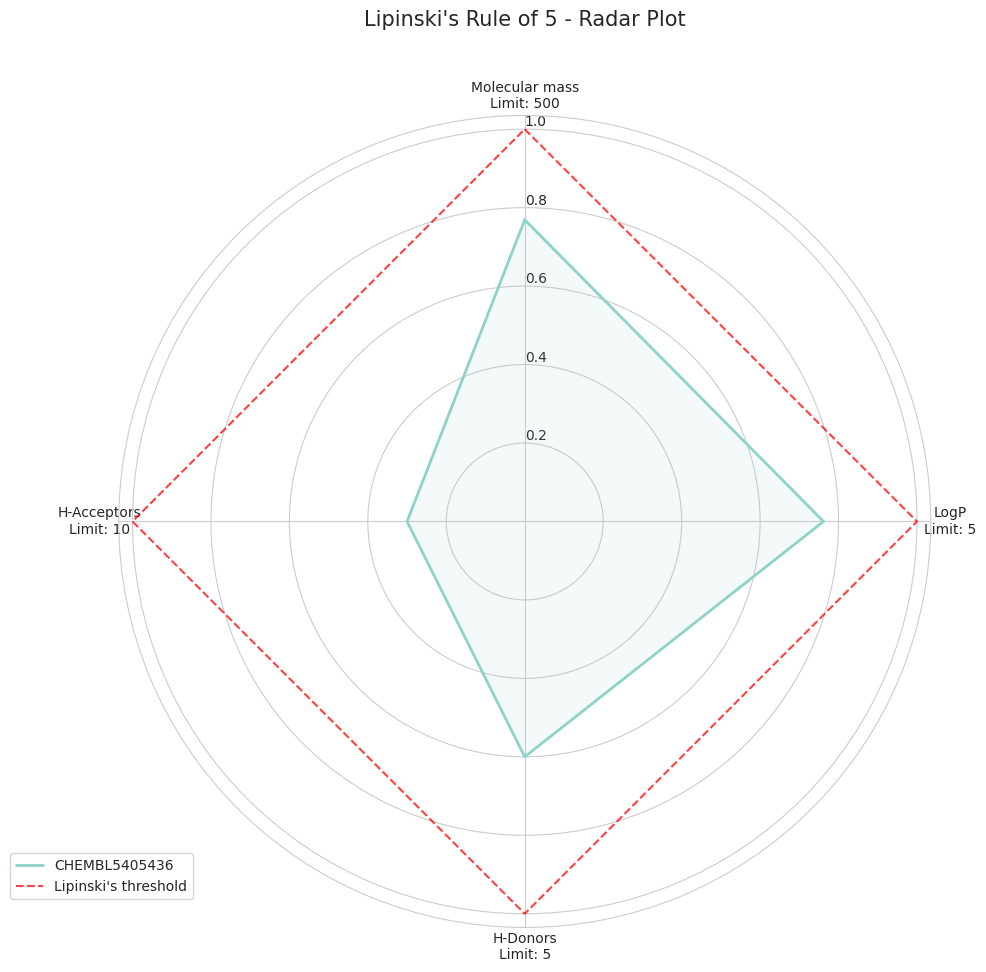

In [26]:
# Create a function for spider/radar plots of compounds
def create_lipinski_radar_plot(df, compounds=None, max_compounds=5):
    """
    Create a radar plot showing Lipinski's parameters for selected compounds
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing Lipinski's parameters
    compounds : list, optional
        List of molecule names to include in the plot
    max_compounds : int, optional
        Maximum number of compounds to display if compounds is None
    """
    # If no compounds specified, select the first max_compounds
    if compounds is None:
        compounds = df['molecule_name'].unique()[:max_compounds]
    else:
        # Ensure all compounds exist in the dataframe
        compounds = [c for c in compounds if c in df['molecule_name'].values]
    
    # Filter dataframe to include only selected compounds
    plot_df = df[df['molecule_name'].isin(compounds)]
    
    # Parameters for the radar plot
    categories = ['Molecular mass', 'LogP', 'H-Donors', 'H-Acceptors']
    
    # Normalize the values for better visualization
    # Set max values based on Lipinski's rule of 5
    max_values = {
        'Molecular mass': 500,
        'LogP': 5,
        'H-Donors': 5,
        'H-Acceptors': 10
    }
    
    # Number of variables
    N = len(categories)
    
    # Create figure and polar subplot
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(111, polar=True)
    
    # Angle for each category
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Add reference circles for Lipinski's thresholds
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    
    # Plot each compound
    for i, name in enumerate(compounds):
        values = plot_df[plot_df['molecule_name'] == name][categories].values[0]
        # Normalize values
        normalized_values = [values[i] / max_values[categories[i]] for i in range(len(categories))]
        normalized_values += normalized_values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, normalized_values, linewidth=2, linestyle='solid', label=name)
        ax.fill(angles, normalized_values, alpha=0.1)
    
    # Set category labels
    plt.xticks(angles[:-1], [f"{cat}\nLimit: {max_values[cat]}" for cat in categories])
    
    # Draw threshold line
    ax.plot(angles, [1] * (N + 1), linewidth=1.5, linestyle='--', color='red', alpha=0.75, label="Lipinski's threshold")
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.title("Lipinski's Rule of 5 - Radar Plot", size=15, y=1.1)
    plt.grid(True)
    
    return fig, ax

# Create radar plot for 5 diverse compounds from the dataset
selected_compounds = lipinski_compliant['molecule_name'].sample(1, random_state=42).tolist()
fig, ax = create_lipinski_radar_plot(lipinski_compliant, compounds=selected_compounds)
plt.tight_layout()
plt.show()